In [2]:
import pandas as pd
import numpy as np
# Load dataset from .parquet file
df = pd.read_csv("dataset/final_data.csv")

# Display first few rows
print(df.head())


                    description  score emoji
0                 grinning face   1.00     😀
1  smiling face with open mouth   1.00     😃
2                  winking face   1.00     😉
3                    robot face   0.50     🤖
4              father christmas   0.75    🎅🏻


In [3]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

# Function to get text embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=50)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy().squeeze()  # Take only CLS token


# Apply to dataset
df["text_embedding"] = df["description"].apply(get_bert_embedding)


/var/home/ujjain/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from gensim.models import KeyedVectors

# Load Emoji2Vec pre-trained embeddings
emoji2vec_model = KeyedVectors.load_word2vec_format("emoji2vec/pre-trained/emoji2vec.bin", binary=True)

# Function to get emoji embeddings
def get_emoji_embedding(emoji):
    try:
        return emoji2vec_model[emoji]
    except KeyError:
        return np.zeros((300,))  # 300D Zero vector if emoji not in vocab


# Apply to dataset
df["emoji_embedding"] = df["emoji"].apply(get_emoji_embedding)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Convert embeddings to NumPy arrays
X_text = np.stack(df["text_embedding"].values)
X_emoji = np.stack(df["emoji_embedding"].values)

# Concatenate text & emoji embeddings
X = np.hstack((X_text, X_emoji))
y = df["score"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 0.0210


In [5]:
import pickle

# Save the model
with open("emoji_sentiment_RFR.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved successfully!")


Model saved successfully!


# model trained on only emoji embeddings 

In [6]:
import pickle
import numpy as np
import gensim
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load Emoji2Vec model
emoji_model = gensim.models.KeyedVectors.load_word2vec_format("emoji2vec/pre-trained/emoji2vec.bin", binary=True)

def get_emoji_embedding(emoji):
    """Extract embedding for a given emoji"""
    try:
        return emoji_model[emoji]
    except KeyError:
        return np.zeros(300)  # Return zero vector if emoji is not found

# Load your dataset (assuming it's a CSV with 'emoji' and 'score' columns)
import pandas as pd
df = pd.read_csv("dataset/final_data.csv")

# Convert emojis to embeddings
X = np.vstack([get_emoji_embedding(e) for e in df["emoji"]])
y = df["score"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the new model
with open("emoji_sentiment_RFR_300d.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model retrained using only 300D emoji embeddings and saved as emoji_sentiment_RFR_300d.pkl")


✅ Model retrained using only 300D emoji embeddings and saved as emoji_sentiment_RFR_300d.pkl


In [21]:
import pickle

# Load the trained model
with open("model/emoji_sentiment_RFR_300d.pkl", "rb") as f:
    model = pickle.load(f)

# Predict sentiment score for an emoji
emoji_embedding = get_emoji_embedding("😟").reshape(1, -1)
predicted_score = model.predict(emoji_embedding)[0]

print(f"Predicted Sentiment Score: {predicted_score}")


Predicted Sentiment Score: 0.2375


# emoji sentiment model using XGBoost and LightGBM to improve accuracy

In [46]:
pip install xgboost lightgbm scikit-learn numpy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [47]:
import gensim
import numpy as np
import pickle
import emoji
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Load Emoji2Vec model
emoji2vec_path = "emoji2vec/pre-trained/emoji2vec.bin"  # Change to your actual path
emoji_model = gensim.models.KeyedVectors.load_word2vec_format(emoji2vec_path, binary=True)

# Load dataset (Replace with your dataset)
import pandas as pd
df = pd.read_csv("dataset/final_data.csv")  # Your dataset with 'emoji' and 'score' columns


In [48]:
def get_emoji_embedding(emoji_char):
    """Extract embedding for a given emoji"""
    try:
        return emoji_model[emoji_char]
    except KeyError:
        return np.zeros(300)  # Return zero vector if emoji not found

# Convert emojis to embeddings
df["emoji_embedding"] = df["emoji"].apply(lambda e: get_emoji_embedding(e))

# Stack embeddings into an array
X = np.vstack(df["emoji_embedding"].values)
y = df["score"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Train LightGBM
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
lgbm_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 300
[LightGBM] [Info] Start training from score 0.638068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(max_depth=5)

In [50]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# Compute Mean Squared Error
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)

print(f"XGBoost MSE: {mse_xgb:.4f}")
print(f"LightGBM MSE: {mse_lgbm:.4f}")


XGBoost MSE: 0.0343
LightGBM MSE: 0.0332


In [51]:
best_model = xgb_model if mse_xgb < mse_lgbm else lgbm_model
model_name = "emoji_sentiment_XGB.pkl" if mse_xgb < mse_lgbm else "emoji_sentiment_LGBM.pkl"

with open(model_name, "wb") as f:
    pickle.dump(best_model, f)

print(f"Best model saved as {model_name}!")


Best model saved as emoji_sentiment_LGBM.pkl!


# implement ensemble learning to combine Random Forest, LightGBM, and XGBoost

In [52]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Train LightGBM
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgbm_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2200, number of used features: 300
[LightGBM] [Info] Start training from score 0.638068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(max_depth=5, random_state=42)

In [53]:
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)


In [54]:
# Weighted averaging (adjust weights based on performance)
y_pred_ensemble = (0.5 * y_pred_rf) + (0.3 * y_pred_lgbm) + (0.2 * y_pred_xgb)

# Calculate the Mean Squared Error (MSE)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
print(f"Ensemble Model MSE: {mse_ensemble:.4f}")


Ensemble Model MSE: 0.0340


In [55]:
import pickle

with open("emoji_sentiment_ensemble.pkl", "wb") as f:
    pickle.dump((rf_model, lgbm_model, xgb_model), f)

print("Ensemble model saved successfully! ✅")


Ensemble model saved successfully! ✅


# neural nets 

In [1]:
from gensim.models import KeyedVectors
import numpy as np

# Load the pretrained Emoji2Vec embeddings
emoji2vec_model = KeyedVectors.load_word2vec_format("emoji2vec/pre-trained/emoji2vec.bin", binary=True)

def get_emoji_embedding(emoji):
    """Fetch emoji embedding from pretrained Emoji2Vec"""
    return emoji2vec_model[emoji] if emoji in emoji2vec_model else np.zeros(300)  # 300-dimensional vector


In [4]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

# 1️⃣ Fast Batch Processing of Text Embeddings (BERT)
def get_text_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs).last_hidden_state.mean(dim=1)
    return outputs.numpy()  # Shape: (N, 768)


In [7]:
# 2️⃣ Precompute Emoji2Vec Embeddings for Unique Emojis
emoji_dict = {emoji: emoji2vec_model[emoji] if emoji in emoji2vec_model else np.zeros(300) for emoji in df["emoji"].unique()}
df["emoji_embedding"] = df["emoji"].map(emoji_dict)

# 3️⃣ Convert to NumPy Arrays for Fast Merging
all_text_embeddings = get_text_embeddings(df["description"].tolist())  # Shape: (N, 768)
all_emoji_embeddings = np.vstack(df["emoji_embedding"].values)  # Shape: (N, 300)

# 4️⃣ Fast Concatenation
X = np.hstack((all_text_embeddings, all_emoji_embeddings))  # Shape: (N, 1068)
y = df["score"].values  # Target labels


In [9]:
from sklearn.model_selection import train_test_split
import torch

# 1️⃣ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2️⃣ Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [12]:
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.metrics import mean_squared_error

class SentimentNN(nn.Module):
    def __init__(self, input_size):
        super(SentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define Model, Loss, and Optimizer
nn_model = SentimentNN(input_size=X.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Train Neural Network
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate Model
y_pred_nn = nn_model(X_test_tensor).detach().numpy().flatten()
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Neural Network MSE: {mse_nn:.4f}")

# Save Model
torch.save(nn_model.state_dict(), "emoji_sentiment_NN.pth")


Epoch 1/100, Loss: 0.4367
Epoch 11/100, Loss: 0.0349
Epoch 21/100, Loss: 0.0274
Epoch 31/100, Loss: 0.0238
Epoch 41/100, Loss: 0.0209
Epoch 51/100, Loss: 0.0184
Epoch 61/100, Loss: 0.0159
Epoch 71/100, Loss: 0.0132
Epoch 81/100, Loss: 0.0103
Epoch 91/100, Loss: 0.0079
Neural Network MSE: 0.0177


# neural nets only for emoji 

In [19]:
import numpy as np

# Precompute Emoji2Vec Embeddings for Unique Emojis
emoji_dict = {emoji: emoji2vec_model[emoji] if emoji in emoji2vec_model else np.zeros(300) for emoji in df["emoji"].unique()}
df["emoji_embedding"] = df["emoji"].map(emoji_dict)

# Convert emoji embeddings to NumPy array
X = np.vstack(df["emoji_embedding"].values)  # Shape: (N, 300)
y = df["score"].values  # Sentiment scores


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

class SentimentNN(nn.Module):
    def __init__(self, input_size=300):  # Input size = 300 for Emoji2Vec embeddings
        super(SentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)  # Output layer (regression)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # No activation for regression
        return x


In [60]:
# Define model, loss function, and optimizer
nn_model = SentimentNN(input_size=300)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 10/200, Loss: 0.0862
Epoch 20/200, Loss: 0.0591
Epoch 30/200, Loss: 0.0431
Epoch 40/200, Loss: 0.0376
Epoch 50/200, Loss: 0.0323
Epoch 60/200, Loss: 0.0309
Epoch 70/200, Loss: 0.0287
Epoch 80/200, Loss: 0.0270
Epoch 90/200, Loss: 0.0257
Epoch 100/200, Loss: 0.0241
Epoch 110/200, Loss: 0.0236
Epoch 120/200, Loss: 0.0226
Epoch 130/200, Loss: 0.0225
Epoch 140/200, Loss: 0.0221
Epoch 150/200, Loss: 0.0216
Epoch 160/200, Loss: 0.0215
Epoch 170/200, Loss: 0.0213
Epoch 180/200, Loss: 0.0211
Epoch 190/200, Loss: 0.0212
Epoch 200/200, Loss: 0.0209


In [61]:
# Save trained model
torch.save(nn_model.state_dict(), "emoji_only_NN.pth")
print("Model saved successfully!")


Model saved successfully!


In [62]:
# Load Model
nn_model.load_state_dict(torch.load("emoji_only_NN.pth"))
nn_model.eval()

# Example emoji
sample_emoji = "😂"

# Convert emoji to embeddings
sample_emoji_embedding = emoji2vec_model[sample_emoji] if sample_emoji in emoji2vec_model else np.zeros(300)  # (300,)

# Convert to PyTorch tensor
sample_tensor = torch.tensor(sample_emoji_embedding, dtype=torch.float32).view(1, -1)

# Predict sentiment
predicted_sentiment = nn_model(sample_tensor).item()
print(f"Predicted Sentiment Score for '{sample_emoji}': {predicted_sentiment:.4f}")


Predicted Sentiment Score for '😂': 0.7884


/tmp/ipykernel_54702/1667140477.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load("emoji_only_NN.pth"))


/tmp/ipykernel_54702/1499896662.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load("emoji_only_NN.pth"))


🔹 Neural Network Performance Metrics (only emoji):
✅ Mean Squared Error (MSE): 0.0323
✅ Mean Absolute Error (MAE): 0.1371
✅ R² Score: 0.4124


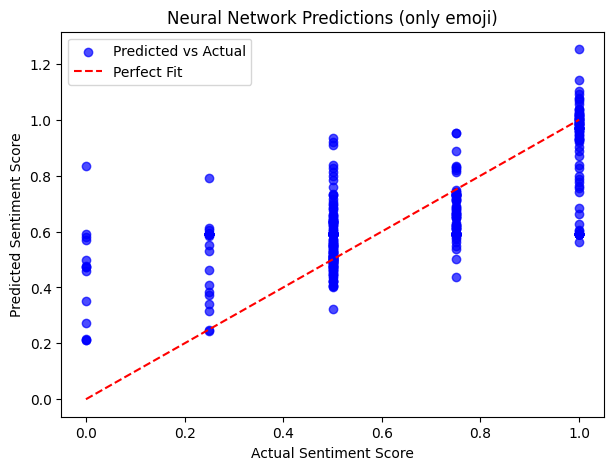

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1️⃣ Load the saved NN model
nn_model = SentimentNN()  
nn_model.load_state_dict(torch.load("emoji_only_NN.pth"))
nn_model.eval()  # Set to evaluation mode


# 2️⃣ Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 3️⃣ Get predictions from the saved model
with torch.no_grad():
    y_pred_tensor = nn_model(X_test_tensor)

# 4️⃣ Convert predictions to NumPy
y_pred = y_pred_tensor.numpy().flatten()
y_test = y_test_tensor.numpy().flatten()

# 5️⃣ Compute Performance Metrics
mse_nn = mean_squared_error(y_test, y_pred)
mae_nn = mean_absolute_error(y_test, y_pred)
r2_nn = r2_score(y_test, y_pred)

print(f"🔹 Neural Network Performance Metrics (only emoji):")
print(f"✅ Mean Squared Error (MSE): {mse_nn:.4f}")
print(f"✅ Mean Absolute Error (MAE): {mae_nn:.4f}")
print(f"✅ R² Score: {r2_nn:.4f}")

# 6️⃣ Plot Predicted vs Actual Values
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predicted vs Actual")
plt.plot([0, 1], [0, 1], '--', color="red", label="Perfect Fit")  # Reference line
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Neural Network Predictions (only emoji)")
plt.legend()
plt.show()


# ensemble learning

In [7]:
import torch

# Load the model
model_path = "model/emoji_sentiment_NN.pth"
model = torch.load(model_path, map_location=torch.device("cpu"))

# Print model architecture
print(model)


OrderedDict({'fc1.weight': tensor([[ 0.0129,  0.0190,  0.0356,  ...,  0.0031,  0.0031, -0.0118],
        [-0.0242, -0.0155,  0.0154,  ..., -0.0445, -0.0314,  0.0078],
        [ 0.0046, -0.0167, -0.0072,  ..., -0.0170,  0.0024, -0.0139],
        ...,
        [-0.0030,  0.0079,  0.0206,  ..., -0.0204, -0.0220, -0.0259],
        [ 0.0181,  0.0177, -0.0119,  ..., -0.0422, -0.0049, -0.0169],
        [ 0.0093, -0.0216, -0.0218,  ..., -0.0120,  0.0049, -0.0103]]), 'fc1.bias': tensor([ 2.0318e-02,  2.0550e-02, -4.6419e-03,  2.2449e-02,  1.6156e-03,
        -2.1387e-02, -2.7166e-02,  7.8298e-03, -4.8363e-03,  5.2323e-03,
        -1.3140e-02,  3.3879e-03, -2.4479e-02,  8.6963e-03, -1.2098e-02,
         1.4406e-02,  1.8580e-02,  1.8092e-02, -1.0340e-04, -1.9432e-02,
        -2.8459e-02, -2.7449e-02,  2.4561e-02,  3.7436e-04, -1.1093e-02,
        -2.0413e-02, -2.5801e-02,  1.7948e-02,  4.1390e-03,  2.8061e-02,
         2.4957e-02,  5.3591e-03,  7.7851e-03,  3.1045e-02,  2.1099e-02,
         2.5555

/tmp/ipykernel_586167/1975310269.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device("cpu"))


In [15]:
pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [8]:
from torchsummary import summary
import torch
state_dict = torch.load("model/emoji_sentiment_NN.pth", map_location=torch.device("cpu"))
print(state_dict.keys())  # Lists layer names and parameters



odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


/tmp/ipykernel_586167/3688790142.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model/emoji_sentiment_NN.pth", map_location=torch.device("cpu")

In [12]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.shape} | Requires Grad: {param.requires_grad}")


Layer: fc1.weight | Size: torch.Size([128, 1068]) | Requires Grad: True
Layer: fc1.bias | Size: torch.Size([128]) | Requires Grad: True
Layer: fc2.weight | Size: torch.Size([64, 128]) | Requires Grad: True
Layer: fc2.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: fc3.weight | Size: torch.Size([1, 64]) | Requires Grad: True
Layer: fc3.bias | Size: torch.Size([1]) | Requires Grad: True


In [11]:
import torch
import torch.nn as nn

# Define the same model architecture used during training
class SentimentNN(nn.Module):
    def __init__(self, input_size):
        super(SentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for regression

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (regression output)
        return x

# Initialize model with correct input size
input_dim = 300 + 768  # Emoji2Vec (300) + BERT (768)
model = SentimentNN(input_dim)

# Load the saved model
model.load_state_dict(torch.load("model/emoji_sentiment_NN.pth", map_location=torch.device("cpu")))
model.eval()  # Set to evaluation mode

# Print model architecture
print(model)


/tmp/ipykernel_586167/2386236898.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/emoji_sentiment_NN.pth", map_location=torch.dev

RuntimeError: Error(s) in loading state_dict for SentimentNN:
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 1068]) from checkpoint, the shape in current model is torch.Size([128, 1068]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([1, 64]).

In [26]:
import requests

response = requests.post("http://127.0.0.1:8000/predict/", json={"emoji": "😟"})
print(response.json())


{'emoji': '😟', 'sentiment_score': 0.035470862435540235}


In [28]:
import requests

url = "http://127.0.0.1:8001/predict/"
data = {
    "text": "i am sad with this",
    "emoji": "😟"
}

response = requests.post(url, json=data)
print(response.json())  # Print the response


{'text': 'i am sad with this', 'emoji': '😟', 'sentiment_score': 0.67}
